In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import math

import DDS_CMpack as CM

%matplotlib inline

data_dir = '/Users/dengdingshan/Documents/GitHub/dds_python/Summer2018/data/'

# Step1 解t0时刻的位置和速度

In [2]:
position_fram = pd.read_csv(data_dir + 'Echo1st.csv')
observe_times = len(position_fram)

In [3]:
position_fram

,UT1_hours,alpha,delta,year,month,days
0,21.575128,142.935000,8.521111,1965,1,14
1,21.603111,157.274167,-2.395000,1965,1,14
2,21.631420,171.817917,-14.508333,1965,1,14
3,21.654491,183.134167,-23.563333,1965,1,14
4,21.714094,208.640417,-40.020278,1965,1,14
5,21.742876,219.102083,-44.998611,1965,1,14


In [4]:
# 常数表
R_earth = 6371
au = 149597870
r_station_earth = 0.999102 #*R_earth
r_earth_sun = 1*au

time_unit = 806.81163 #806.8116 # SI 

# 测站的地理位置
lam = 118.82091666 # degrees
phi = 31.893611111 # degrees

# headers index: UT1_hours  alpha  delta  year  month  days

UT1_hours = position_fram['UT1_hours']
alpha = position_fram['alpha']
delta = position_fram['delta']
year = position_fram['year']
month = position_fram['month']
days = position_fram['days']


In [5]:
# 进行拉普拉斯方法所需要的星表归算

P = []
Q = []
Lambda_all = []
Niu_all = []
Miu_all = []
X_all = [];Y_all = [];Z_all = []

for i in range(observe_times):   
    # 计算观测数据的儒略日时间和恒星时
    SG_s,jd_s = CM.UTC2SG(year[i],month[i],days[i],UT1_hours[i])
    SG_degree = SG_s%(3600*24)/(3600*24)*360
    
    # 通过每一个恒星时去归算出测站到地心的RA,DEC
    RA_station = SG_degree + lam
    DEC_station = phi
    station_earth = CM.RADEC2xyz(r_station_earth,RA_station,DEC_station)
    
    X,Y,Z = station_earth
    X_all.append(X);
    Y_all.append(Y);
    Z_all.append(Z)
    
    # 再根据测站到地心的位置最终算出Pj,Qj
    delta_rad = np.deg2rad(delta[i])
    alpha_rad = np.deg2rad(alpha[i])
    
    Lambda = np.cos(delta_rad)*np.cos(alpha_rad)
    Miu = np.cos(delta_rad)*np.sin(alpha_rad)
    Niu = np.sin(delta_rad)
    Lambda_all.append(Lambda)
    Miu_all.append(Miu)
    Niu_all.append(Niu)
    
    P_j = Niu*X - Lambda*Z
    Q_j = Niu*Y - Miu*Z
    
    P.append(P_j);Q.append(Q_j)

PF_fill = position_fram
PF_fill['P'] = np.array(P)
PF_fill['Q'] = np.array(Q)
PF_fill['Lambda'] = np.array(Lambda_all)
PF_fill['Miu'] = np.array(Miu_all)
PF_fill['Niu'] = np.array(Niu_all)
PF_fill['X'] = np.array(X_all)
PF_fill['Y'] = np.array(Y_all)
PF_fill['Z'] = np.array(Z_all)

# 为了避免和底下计算轨道根数时用到的P,Q（坐标轴指向）产生冲突，此处将P,Q重新命名为Pj,Qj以便使用
Pj = P; Qj = Q

In [6]:
PF_fill

,UT1_hours,alpha,delta,year,month,days,P,Q,Lambda,Miu,Niu,X,Y,Z
0,21.575128,142.935000,8.521111,1965,1,14,0.296272,-0.351086,-0.789144,0.596067,0.148174,-0.811836,-0.245928,0.527869
1,21.603111,157.274167,-2.395000,1965,1,14,0.520311,-0.193223,-0.921558,0.385984,-0.041788,-0.810008,-0.251885,0.527869
2,21.631420,171.817917,-14.508333,1965,1,14,0.708283,-0.008122,-0.958257,0.137781,-0.250521,-0.808114,-0.257898,0.527869
3,21.654491,183.134167,-23.563333,1965,1,14,0.805554,0.131507,-0.915248,-0.050115,-0.399763,-0.806537,-0.262787,0.527869
4,21.714094,208.640417,-40.020278,1965,1,14,0.870732,0.370844,-0.672115,-0.367065,-0.643059,-0.802327,-0.275374,0.527869
5,21.742876,219.102083,-44.998611,1965,1,14,0.855495,0.434417,-0.548745,-0.445986,-0.707090,-0.800223,-0.281429,0.527869


In [7]:
# t0的值要预先给定，这个值在这种写法底下使用24小时的单位值（粗略的换算）
# t0 = (PF_fill['UT1_hours'].values[0]+PF_fill['UT1_hours'].values[5])/2
t0 = (PF_fill['UT1_hours'].sum())/6

# 给定所需要的按照理论单位的时间值
T = (PF_fill['UT1_hours'] - t0)*3600/time_unit
F0 = np.ones(observe_times).tolist()
G0 = T.tolist()

In [8]:
def F_expansion(r,v,t):
    s = np.dot(r,v)
    u = 1/r
    
    Out = 1 - 0.5*(u**3)*(t**2) + 0.5*(u**5)*s*(t**3) + 1/24*(u**5)*(3*(v**2) - 2*u - 15*(u**2)*(s**2))
    return Out

def G_expansion(r,v,t):
    s = np.dot(r,v)
    u = 1/r
    
    Out = t - 1/6*(u**3)*(t**3) + 1/4*(u**5)*s*(t**4) + 1/120*(u**5)*(9*(v**2) - 8*u -45*(u**2)*(s**2))*(t**5)
    return Out

In [9]:
# 选定用于归算轨道六根数的数据点（观测序数）
Ob_index = [i for i in range(6)]
# Ob_index = [1,3,5]

############################################

# Laplace循环长数值和初值
F = [ F0[i] for i in Ob_index ]
G = [ G0[i] for i in Ob_index ]
Niu = Niu_all
Miu = Miu_all
Lambda = Lambda_all

# Laplace循环
Nwind = 0
key = 0
while key == 0:
    A = []
    b = []
    nwind = 0 # 用于索引循环中的F,G的list
    # 构造系数矩阵和常数阵
    for j in Ob_index:
         
        A.append([Niu[j]*F[nwind],0,-Lambda[j]*F[nwind],Niu[j]*G[nwind],0,-Lambda[j]*G[nwind]])
        A.append([0,Niu[j]*F[nwind],-Miu[j]*F[nwind],0,Niu[j]*G[nwind],-Miu[j]*G[nwind]])
        b.append(Pj[j])
        b.append(Qj[j])
        
        nwind += 1
    
    AA = np.array(A)
    b = np.array(b)
    
    # 解出r0和V0
    ans = np.linalg.solve(np.dot(AA.T.copy(),AA),np.dot(AA.T.copy(),b))
    r0 = ans[:3]
    v0 = ans[3:]
        
    # 用r0和v0求出新的F和G
    norm_r0 = np.sqrt(np.dot(r0,r0))
    norm_v0 = np.sqrt(np.dot(v0,v0))
    
    F_old = F; G_old = G
    F = [];G = []
    for k in Ob_index:
        F.append(CM.F(norm_r0,norm_v0,T[k]))
        G.append(CM.G(norm_r0,norm_v0,T[k]))
    
    # 上述循环完成，计数一次
    Nwind += 1
    
    # 判断是否跳出循环
    # 取F,G的二范数的最大值判断是否小于我们所需的精度
    delta_F = np.linalg.norm(np.array(F) - np.array(F_old), 2)
    delta_G = np.linalg.norm(np.array(G) - np.array(G_old), 2)
    biggest = np.max([delta_F,delta_G])
    if biggest < 1e-13:
        print('end: ',int(Nwind))
        print(r0,v0)
        key = 1

end:  79
[-1.12399156 -0.27932053  0.39153599] [-0.03181413 -0.6382986  -0.58350346]


In [10]:
print(r0*R_earth, norm_r0*R_earth, (norm_r0-r_station_earth)*R_earth)

print(v0*R_earth/time_unit, norm_v0*R_earth/time_unit)

print(t0*3600)

[-7160.95022294 -1779.55112547  2494.47581014] 7788.993508210909 1423.7146662109083
[-0.25122073 -5.04033439 -4.6076437 ] 6.833627372532913
77952.67183199999


# Step 2 解轨道六根数

In [11]:
# # 取轨国际单位制的常数表

# R_earth = 6371e3 # m

# M_earth = 5.965e24 # kg
# G_graviation = 6.672e-11 # N·m^2 /kg^2 

# au = 149597870e3 # m
# r_station_earth = 0.999102 #*R_earth
# r_earth_sun = 1*au

# # time_unit = 806.81163 #806.8116 # SI 

# # miu_GM = 398600.5e-6 # km^3/SI^2

# miu_GM = G_graviation*M_earth # m^3/SI^2

## 还是先继续使用已经在使用的理论单位！

miu_GM = 1

R_earth = 1

In [12]:
# rg = r0*R_earth
# norm_rg = np.sqrt(np.dot(rg,rg))
# vg = v0*R_earth/time_unit
# norm_vg = np.sqrt(np.dot(vg,vg))
# tg = t0*time_unit

rg = r0
norm_rg = np.sqrt(rg.dot(rg))
vg = v0
norm_vg = np.sqrt(vg.dot(vg))

In [13]:
a = (2/norm_rg - (norm_vg**2)/miu_GM)**(-1)
a

1.1274152764273662

In [14]:
n = np.sqrt(miu_GM/(a**3))
n

0.8353608681485124

In [15]:
e = np.sqrt( (1 - norm_rg/a)**2 + (rg.dot(vg) / (n*a**2))**2)
e

0.08548550663709367

In [16]:
cos_E = (1 - norm_rg/a)/e
sin_E = (rg.dot(vg) / ((a**2)*n))/e
E = math.atan2(sin_E,cos_E)

E

-2.9821189589938917

In [17]:
M = E - e*math.sin(E)

In [18]:
P = (cos_E/norm_rg)*rg - (sin_E/(a*n))*vg
Q = (sin_E/(norm_rg)*np.sqrt(1-e**2))*rg + ((cos_E - e)/(a*n*np.sqrt(1-e**2)))*vg
R = np.cross(P,Q)
P,Q

(array([ 0.90233774,  0.11794607, -0.41457848]),
 array([0.18183231, 0.76590091, 0.61643677]))

In [19]:
pz = P[2]; qz = Q[2]
tan_w_raw = pz/qz
if pz >=0 and qz >= 0:
    # w I
    w = math.atan(tan_w_raw)
elif pz >= 0 and qz < 0:
    # w II
    w = math.atan(tan_w_raw) + np.pi
elif pz < 0 and qz < 0:
    # w III
    w = math.atan(tan_w_raw) + np.pi
elif pz < 0 and qz >= 0:
    # w IV
    w = math.atan(tan_w_raw) + 2*np.pi

In [20]:
h = np.cross(rg,vg)
norm_h = np.sqrt(np.dot(h,h))

h_A, h_B, h_C = h[0:3]

# get cos_i, sin_i
cos_i = (h_C/norm_h)
tan_i = np.sqrt(h_A**2 + h_B**2) / h_C

sin_i = tan_i*cos_i

# get cos_\sin_Omega
sin_Omega = h_A/(norm_h*sin_i)
cos_Omega = -h_B/(norm_h*sin_i)

i_fin = math.atan2(sin_i,cos_i)
Omega = math.atan2(sin_Omega,cos_Omega)

In [21]:
print(a,e,M,i_fin,Omega,w)

1.1274152764273662 0.08548550663709367 -2.968543980089816 0.8368990606009702 0.5534265399652797 5.691127456981064


In [22]:
np.rad2deg([M,i_fin,Omega,w])

array([-170.08504136,   47.95078405,   31.70900501,  326.07758396])

# Step 3 反算星历表


In [23]:
t3 = t0
T3 = (PF_fill['UT1_hours'] - t3)*3600/time_unit

In [24]:
M_total = M + n*T3

In [25]:
# 迭代 开普勒方程解 E
E_total = []
for i in range(len(M_total)):
    epsilon = 1e-10
    key = 0
    En0 = M_total[i]
    
    En_new = En0
    while key == 0:
        En_old = En_new
        En_new = En_old - (En_old - M_total[i] - e*np.sin(En_old))/(1-e*np.cos(En_old))
        delta_En = np.abs(En_new - En_old)

        if delta_En < epsilon:
            key = 1;

    E_total.append(En_new)

In [26]:
# 计算新的 P,Q 

P_new = np.array([np.cos(Omega)*np.cos(w-2*np.pi) - np.sin(Omega)*np.sin(w)*np.cos(i_fin),\
                 np.sin(Omega)*np.cos(w-2*np.pi) + np.cos(Omega)*np.sin(w)*np.cos(i_fin),\
                 np.sin(w)*np.sin(i_fin)])
Q_new = np.array([-np.cos(Omega)*np.sin(w) - np.sin(Omega)*np.cos(w)*np.cos(i_fin),\
                 -np.sin(Omega)*np.sin(w) + np.cos(Omega)*np.cos(w)*np.cos(i_fin),\
                 np.cos(w)*np.sin(i_fin)])

P_new,Q_new

(array([ 0.90238898,  0.11816085, -0.41440577]),
 array([0.18265016, 0.76613392, 0.61617996]))

In [27]:
P,Q

(array([ 0.90233774,  0.11794607, -0.41457848]),
 array([0.18183231, 0.76590091, 0.61643677]))

In [28]:
# 计算新的 r,v
Rt = [];Vt = []
for Et in E_total:
    rt = a*(np.cos(Et) - e)*P_new + a*np.sqrt(1 - e**2)*np.sin(Et)*Q_new
    rt_norm = np.sqrt( np.dot(rt,rt) )

    vt = -a**2*n/rt_norm*np.sin(Et)*P_new + a**2*n/rt_norm*np.sqrt(1 - e**2)*np.cos(Et)*Q_new
    vt_norm = np.sqrt( np.dot(vt,vt) )

    L_rt = rt/ np.sqrt( np.dot(rt,rt))

    print(rt_norm,vt_norm)
    
    Rt.append(rt)
    Vt.append(vt)

1.223212756281499 0.8649011099863617
1.2237839278025013 0.8644598402472898
1.2234568359641753 0.8647125185910632
1.2225183708417766 0.8654378228771759
1.2173378029754711 0.8694508237610745
1.2134478861443727 0.8724743141114455


In [29]:
PF_fill.loc[1,'X']

-0.8100079092120175

In [30]:
# 归算最终的赤经赤纬
# 先获得方向矢量L，再从L归算预测的alpha和delta值
P_earth = Rt
P_station = []
L_forecast_total = []

for j in range(observe_times):
    station_earth = np.array([PF_fill.loc[j,'X'],PF_fill.loc[j,'Y'],PF_fill.loc[j,'Z']])*R_earth
    P_station = np.array(P_earth[j] - station_earth)
    L_forecast = np.true_divide(P_station,np.linalg.norm(P_station,2))
    L_forecast_total.append(L_forecast)

L_fa = np.array(L_forecast_total)

L_fa

array([[-0.79225023,  0.58965222,  0.15700266],
       [-0.92512605,  0.37796183, -0.03586983],
       [-0.95994348,  0.12998264, -0.24821971],
       [-0.91455266, -0.05630093, -0.40052919],
       [-0.66482509, -0.36723484, -0.65049686],
       [-0.53811828, -0.44333787, -0.71685442]])

In [31]:
# 计算delta 和alpha
# delta in [-180,180]
Delta_forecast = np.rad2deg(np.arcsin(L_fa[:,2]))

# alpha in [0,360]
Alpha_forecast_raw = np.rad2deg(np.arctan2(L_fa[:,1],L_fa[:,0]))
Alpha_forecast = []
for a in Alpha_forecast_raw:
    if a > 0:
        Alpha_forecast.append(a)
    else:
        Alpha_forecast.append(360 + a)
    
Alpha_forecast = np.array(Alpha_forecast)

In [32]:
PF_fill

,UT1_hours,alpha,delta,year,month,days,P,Q,Lambda,Miu,Niu,X,Y,Z
0,21.575128,142.935000,8.521111,1965,1,14,0.296272,-0.351086,-0.789144,0.596067,0.148174,-0.811836,-0.245928,0.527869
1,21.603111,157.274167,-2.395000,1965,1,14,0.520311,-0.193223,-0.921558,0.385984,-0.041788,-0.810008,-0.251885,0.527869
2,21.631420,171.817917,-14.508333,1965,1,14,0.708283,-0.008122,-0.958257,0.137781,-0.250521,-0.808114,-0.257898,0.527869
3,21.654491,183.134167,-23.563333,1965,1,14,0.805554,0.131507,-0.915248,-0.050115,-0.399763,-0.806537,-0.262787,0.527869
4,21.714094,208.640417,-40.020278,1965,1,14,0.870732,0.370844,-0.672115,-0.367065,-0.643059,-0.802327,-0.275374,0.527869
5,21.742876,219.102083,-44.998611,1965,1,14,0.855495,0.434417,-0.548745,-0.445986,-0.707090,-0.800223,-0.281429,0.527869


# Step 4 计算残差数据

In [33]:
delta_AlphaCosDelta = Alpha_forecast*np.cos(np.deg2rad(Delta_forecast)) \
                    - PF_fill['alpha']*np.cos(np.deg2rad(PF_fill['delta']))
delta_Delta = Delta_forecast - PF_fill['delta']

pd.DataFrame({'$ \Delta a\cos\delta $': np.array(delta_AlphaCosDelta),
             '$ \Delta\delta $ ':np.array(delta_Delta)})

,$ \Delta a\cos\delta $,$ \Delta\delta $
0,0.205730,0.511851
1,0.539127,0.339369
2,0.557837,0.136145
3,0.294749,-0.047931
4,-1.107319,-0.558796
5,-1.903070,-0.796771


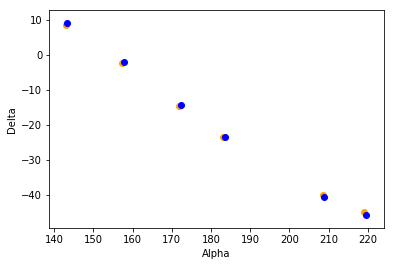

In [34]:
plt.figure()

plt.xlabel('Alpha')
plt.ylabel('Delta')

plt.scatter(PF_fill['alpha'],PF_fill['delta'],c = 'orange')
plt.scatter(Alpha_forecast,Delta_forecast,c = 'b')

plt.show()

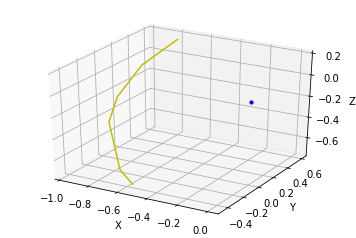

In [35]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
#  将数据点分成三部分画，在颜色上有区分度
ax.plot(L_fa[:,0], L_fa[:,1], L_fa[:,2], c='y')  # 绘制数据点
ax.scatter(0,0,0,c= 'b',s = 10)

ax.set_zlabel('Z')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()